In [1]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from utils.GridWorldPitfalls import GridWorldWithPitfalls
from utils.GridWorldPeriodicTerminal import GridWorldPeriodicTerminal, PeriodicRewardState
from utils import *
from tqdm import tqdm
import cv2

# Sarsa: On-Policy TD Control
## Sarsa: State-Action-Reward-State-Action
当谈到Control的时候，就是指我们在循环的过程中，action-value和policy不断地交替更新，最终实现收敛，也就是Generalized Policy Iteration (GPI)。<p>
$$Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma Q(s',a') - Q(s,a) \right]$$
书里原公式为：
$$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \left[ R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t) \right]$$
这个公式就是TD(0)的公式换成了action-value的更新。<p>


$Q(S_t,A_t)$是当前状态和动作的action-value，我们要bootstrap，因此就是要用旧的来估计新的，注意等式右边除了$R_{t+1}$没一个东西是新的<p>
$R_{t+1} + \gamma Q(S_{t+1},A_{t+1})$是我们根据实际获得的reward和下一个状态的旧action-value算出来的新的action-value估计值。<p>
那么$R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t)$就是我们的error，是新估计值和旧估计值的差。<p>
然后这个差乘上step-size，就是我们要更新的量。最后把这个更新的量加到当前action-value上，就更新了action-value<p>

<mark>注意！！！一定要在terminal state时设置terminal state的action-value因为在terminal state时你拿不到下一个action-value，因此我之前把它忽略掉了，导致action-value在碰到terminal state时无法得到来自terminal state的reward(其实是-1的penalty)，最终导致policy不知道去躲避陷阱terminal state。</mark><

Sarsa:  12%|█▏        | 1200/10000 [00:10<01:13, 119.31it/s]


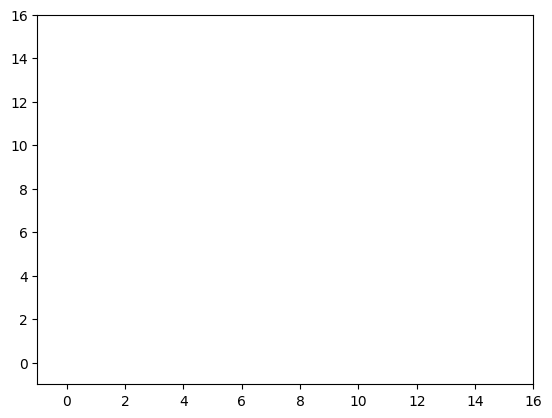

In [2]:
def Sarsa(grid_world: GridWorldPeriodicTerminal):
    agent = Agent(grid_world, Policy(grid_world))
    # Make state value of terminal state
    agent.initTerminalValues(grid_world)
    gamma = 0.9
    step_size = 0.2

    for it in tqdm(range(10000), desc="Sarsa"):
        # initialize eposide with non terminal state
        grid_world.reset(0)
        while grid_world.isTerminalState(grid_world.start_sid):
            grid_world.reset(0)  # reset with a random start state

        agent.policy = agent.action_value.copy(grid_world)
        agent.policy.normalize()

        # get first state and action
        old_sid = grid_world.start_sid
        old_aid = agent.takeAction(old_sid, epsilon=0.4)

        while True:
            # random_action_id = np.random.randint(0, grid_world.n_actions)
            r = grid_world.step(old_aid)
            new_sid = grid_world.current_sid

            # update state value
            agent.state_value[old_sid] += step_size * (r + gamma * agent.state_value[new_sid] - agent.state_value[old_sid])

            if grid_world.isTerminalState(grid_world.current_sid):
                ### --- Action value for terminal state --- ###
                agent.action_value[old_sid, old_aid] += step_size * (r - agent.action_value[old_sid, old_aid])
                break

            # take new action
            new_aid = agent.takeAction(new_sid, epsilon=0.4)

            # update action value
            agent.action_value[old_sid, old_aid] += step_size * (r + gamma * agent.action_value[new_sid, new_aid] - agent.action_value[old_sid, old_aid])

            old_aid = new_aid
            old_sid = new_sid

        # update terminal state reward
        if PeriodicRewardState.reward_changed:
            for sid in grid_world.getTerminalStateIds():
                agent.state_value[sid] = grid_world.states[sid].getReward()
            PeriodicRewardState.reward_changed = False

        if it % 100 == 0:
            agent.policy.normalize()
            img = grid_world.render(agent, figsize=(10, 10))
            cv2.imshow("img", img)
            k = cv2.waitKey(1)
            if k == ord("q"):
                break
    cv2.destroyAllWindows()

Sarsa(GridWorldPeriodicTerminal(world_size=16, 
                        win_states=[(10, 2), (4, 10), (14, 14)], 
                        fail_states=[(4, 4), (6, 6), (10, 10), (12, 12)]
                        )
    )

In [9]:
def Sarsa(grid_world: GridWorldWithPitfalls):
    agent = Agent(grid_world, Policy(grid_world))
    # Make state value of terminal state
    agent.initTerminalValues(grid_world)
    gamma = 0.9
    step_size = 0.1

    for it in tqdm(range(4000), desc="Sarsa"):
        # initialize eposide with non terminal state
        grid_world.reset(10)
        while grid_world.isTerminalState(grid_world.start_sid):
            grid_world.reset(10)  # reset with a random start state

        agent.policy = agent.action_value.copy(grid_world)
        agent.policy.normalize()

        # get first state and action
        old_sid = grid_world.start_sid
        old_aid = agent.takeAction(old_sid, epsilon=0.4)

        while True:
            # random_action_id = np.random.randint(0, grid_world.n_actions)
            r = grid_world.step(old_aid)
            new_sid = grid_world.current_sid

            # update state value
            agent.state_value[old_sid] += step_size * (r + gamma * agent.state_value[new_sid] - agent.state_value[old_sid])

            if grid_world.isTerminalState(grid_world.current_sid):
                ### --- Action value for terminal state --- ###
                agent.action_value[old_sid, old_aid] += step_size * (r - agent.action_value[old_sid, old_aid])
                break

            # take new action
            new_aid = agent.takeAction(new_sid, epsilon=0.4)

            # update action value
            agent.action_value[old_sid, old_aid] += step_size * (r + gamma * agent.action_value[new_sid, new_aid] - agent.action_value[old_sid, old_aid])

            old_aid = new_aid
            old_sid = new_sid

    grid_world.reset(10)
    for sid in grid_world.getNonTerminalStateIds():
        best_action_id = agent.action_value[sid].argmax()
        agent.policy[sid] = 0
        agent.policy[sid, best_action_id] = 1

    # Run another time to get path
    grid_world.reset(10)
    while not grid_world.isTerminalState(grid_world.current_sid):
        action_id = agent.takeAction(grid_world.current_sid, epsilon=0)
        grid_world.step(action_id)

    grid_world.render(agent, figsize=(10, 10))
    plt.show()

Sarsa: 100%|██████████| 4000/4000 [00:04<00:00, 913.66it/s]


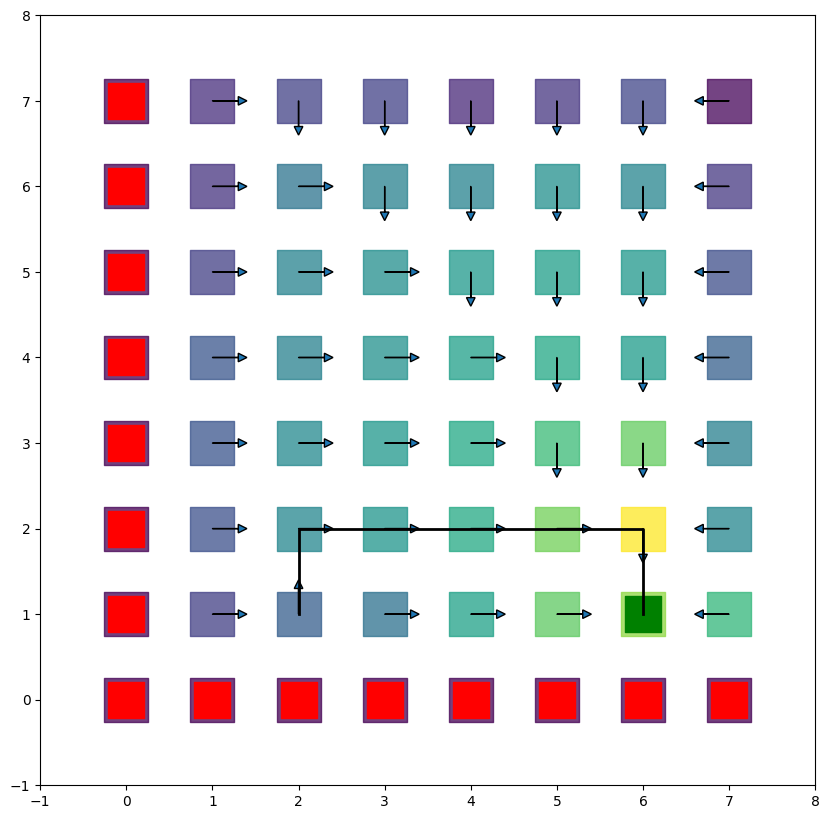

In [11]:
Sarsa(GridWorldWithPitfalls(world_size=8, 
                            win_states=[(1, 6)], 
                            fail_states=[(0, i) for i in range(8)] + [(i, 0) for i in range(8)]))